In [60]:
import os.path, pandas as pd 
import matplotlib as mp, matplotlib.pyplot as plt
import numpy as np, json, random, ast
from IPython.display import clear_output
from pandas.io.json import json_normalize, read_json
from datetime import datetime
from IPython.display import HTML
import cesiumpy

import sklearn as skl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

#Set some parameters for nicer visualizations
pd.set_option('display.expand_frame_repr', False) #do not wrap the printout of Pandas DataFrames
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', 50)
mp.rcParams['figure.figsize'] = (15, 15)
mp.pyplot.style.use = 'fivethirtyeight'
%matplotlib inline

In [25]:
def plot_roc(y_test, y_pred, caption):
    fpr, tpr, thresholds = skl.metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = skl.metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area ={0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
    plt.legend(loc="lower right")
    plt.show();

In [26]:
dfmain = pd.read_csv('data/dffinal.csv', index_col=0)
dfmain['geojson'] = dfmain['geojson'].map(ast.literal_eval) #convert string to dict
dfmain['sta'] = pd.to_datetime(dfmain['sta'])
dfmain['end'] = pd.to_datetime(dfmain['end'])
dfmain['duration'] = pd.to_timedelta(dfmain['duration'])   
dfmain.sample()

,icao,s,iata,wkt,geojson,sta,end,duration,rwys,humidity,dewPoint,temperature,pressure,visibility,windBearing,windSpeed,windGust,precipIntensity,precipProbability,storm,dat.cape,dat.tempk,dat.press,dat.humi,dat.precip,crosswind,cap,demand,ratio,regulated
2144,LEBB,Place_Bilbao___Sondica,BIO,POINT (-2.910555601119995 43.301109313964844),"{'type': 'Point', 'coordinates': [-2.910555601...",2016-04-13 18:00:00,2016-04-13 18:59:59,00:59:59,300,0.34,3.22,19.6,1010.87,10.27,249.0,2.08,0.0,0.0,0.0,0,405.0,18.0,98838.57,55.0,1.00e-04,1.62,22,5.0,0.23,0


In [27]:
# 0. Create the feature matrix and label vector as numpy-Arrays.
X = np.array(dfmain[['humidity', 'dewPoint', 'temperature', 
                    'pressure', 'visibility', 'windSpeed', 
                    'precipIntensity', 'precipProbability', 
                    'dat.cape', 'crosswind', 'ratio']])
y = np.array(dfmain['regulated'])
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

### Classifier from previous Notebok

In [28]:
normer = preprocessing.StandardScaler()
svm1 = svm.SVC(probability=True, class_weight={1: 10})
pipe_1 = Pipeline(steps=[('normalization', normer), ('svm', svm1)])

cv = skl.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
#params = [ {"svm__kernel": ["linear"], "svm__C": [1, 10, 100, 1000]}, 
#               {"svm__kernel": ["rbf"], "svm__C": [1, 10, 100, 1000], "svm__gamma": [0.001, 0.0001]} ]
params = [ {"svm__kernel": ["rbf"], "svm__C": [750, 1000, 1250], "svm__gamma": [0.01, 0.008, 0.005, 0.003, 0.001]} ]
grd = GridSearchCV(pipe_1, params, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1)

### Classifier Training

In [29]:
# fit the classifier on training set and predict on test set in one line (takes around 5 minutes):
#y_pred = grd.fit(X_train, y_train).predict(X_test)
y_pred = grd.fit(X_train, y_train).predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] svm__C=750, svm__gamma=0.01, svm__kernel=rbf ....................
[CV] svm__C=750, svm__gamma=0.01, svm__kernel=rbf ....................
[CV] ..... svm__C=750, svm__gamma=0.01, svm__kernel=rbf, total=   3.2s
[CV] svm__C=750, svm__gamma=0.01, svm__kernel=rbf ....................
[CV] ..... svm__C=750, svm__gamma=0.01, svm__kernel=rbf, total=   3.4s
[CV] svm__C=750, svm__gamma=0.01, svm__kernel=rbf ....................
[CV] ..... svm__C=750, svm__gamma=0.01, svm__kernel=rbf, total=   3.0s
[CV] svm__C=750, svm__gamma=0.01, svm__kernel=rbf ....................
[CV] ..... svm__C=750, svm__gamma=0.01, svm__kernel=rbf, total=   3.1s
[CV] svm__C=750, svm__gamma=0.008, svm__kernel=rbf ...................
[CV] ..... svm__C=750, svm__gamma=0.01, svm__kernel=rbf, total=   3.1s
[CV] svm__C=750, svm__gamma=0.008, svm__kernel=rbf ...................
[CV] .... svm__C=750, svm__gamma=0.008, svm__kernel=rbf, total=   3.0s
[CV] svm__C=750,

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


[CV] ... svm__C=1000, svm__gamma=0.005, svm__kernel=rbf, total=   3.2s
[CV] svm__C=1000, svm__gamma=0.005, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.005, svm__kernel=rbf, total=   3.5s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.005, svm__kernel=rbf, total=   3.8s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   2.8s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   3.0s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   2.9s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   2.9s
[CV] svm__C=1000, svm__gamma=0.001, svm__kernel=rbf ..................
[CV] .

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.2min finished


### Classifier Evaluation

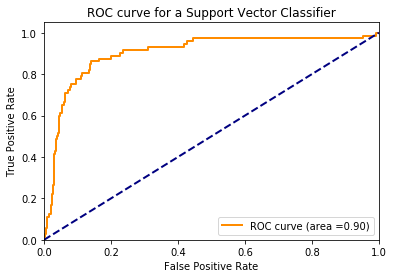

This AUC has been achieved with the following parameters:
{'svm__C': 750, 'svm__gamma': 0.008, 'svm__kernel': 'rbf'}
 


In [30]:
#confmatrix = skl.metrics.confusion_matrix(y_test, y_pred)
plot_roc(y_test, y_pred, 'ROC curve for a Support Vector Classifier')
print('This AUC has been achieved with the following parameters:')
print( grd.best_params_ )
print(' ')
#print('The Confusion Matrix for the default threshold is:')
#print(confmatrix)

### Gathering Predictions for an Example Visualization

We are going to show regulation probabilities for each of our airports of intereset, for each hour of an example day. To accomplish this, we need to .predict() $y_{pred}$ on the main DataFrame, without loosing the references. Good for us: despite shuffling the data during training, at prediction time, our classifier will not shuffle the data.

In [99]:
# Generate Boolean Masks for start and end time
startmask = (dfmain['sta'] >= pd.to_datetime('2016-04-11T00:00:00') )
endmask   = (dfmain['sta'] < pd.to_datetime('2016-04-12T00:00:00') )
dfviz = dfmain[startmask & endmask].copy()


# Create the feature matrix without label vector as numpy-Array.
X = np.array(dfviz[['humidity', 'dewPoint', 'temperature', 
                    'pressure', 'visibility', 'windSpeed', 
                    'precipIntensity', 'precipProbability', 
                    'dat.cape', 'crosswind', 'ratio']])
y_pred = grd.predict_proba(X)

In [100]:
dfviz['y_pred'] = y_pred[: , 1]
dfviz.sample(5)

,icao,s,iata,wkt,geojson,sta,end,duration,rwys,humidity,dewPoint,temperature,pressure,visibility,windBearing,windSpeed,windGust,precipIntensity,precipProbability,storm,dat.cape,dat.tempk,dat.press,dat.humi,dat.precip,crosswind,cap,demand,ratio,regulated,y_pred
1742,LEVC,Place_Valencia_Manises_Airport,VLC,POINT (-0.4816666543483734 39.489444732666016),"{'type': 'Point', 'coordinates': [-0.481666654...",2016-04-11 08:00:00,2016-04-11 08:59:59,00:59:59,300,0.53,6.11,15.53,1011.46,10.35,259.0,4.53,0.0,0.00,0.00,0,0.0,14.7,100544.01,79.1,0.00e+00,2.97,34,8.0,0.24,0,2.26e-02
1798,LEVC,Place_Valencia_Manises_Airport,VLC,POINT (-0.4816666543483734 39.489444732666016),"{'type': 'Point', 'coordinates': [-0.481666654...",2016-04-11 16:00:00,2016-04-11 16:59:59,00:59:59,300,0.66,11.37,17.78,1009.53,11.57,134.0,6.19,0.0,0.03,0.10,0,0.0,15.9,101210.90,60.9,0.00e+00,1.50,34,8.0,0.24,0,1.52e-03
1814,LEBL,Place_Barcelona_ElPrat_Airport,BCN,POINT (2.0783333778381348 41.29694366455078),"{'type': 'Point', 'coordinates': [2.0783333778...",2016-04-11 19:00:00,2016-04-11 19:59:59,00:59:59,250,0.63,7.87,14.92,1010.85,15.80,227.0,4.62,0.0,0.00,0.00,0,0.0,18.0,98375.70,53.2,0.00e+00,1.81,72,52.0,0.72,0,7.01e-02
1720,LEPA,Place_Palma_de_Mallorca___Son_San_Juan,PMI,POINT (2.73888897895813 39.551666259765625),"{'type': 'Point', 'coordinates': [2.7388889789...",2016-04-11 05:00:00,2016-04-11 05:59:59,00:59:59,240,0.93,11.13,12.23,1009.70,9.98,340.0,0.43,0.0,0.05,0.05,0,0.0,17.3,100086.41,51.6,0.00e+00,0.42,66,17.0,0.26,0,6.57e-03
1787,LEBB,Place_Bilbao___Sondica,BIO,POINT (-2.910555601119995 43.301109313964844),"{'type': 'Point', 'coordinates': [-2.910555601...",2016-04-11 15:00:00,2016-04-11 15:59:59,00:59:59,300,0.36,3.03,18.34,1006.37,10.15,201.0,2.10,0.0,0.00,0.00,0,252.0,14.4,98447.70,83.9,6.00e-05,2.07,22,5.0,0.23,0,6.68e-04


### CZML Function Definitions:

The following function definitions are adapted from our Appendix B, where we created the Cesium.js heatmap. Now we want to use this heatmap to visualize the regulation probabilities on the given day for each of our airports of interest. We replace the function create_czml_airspace with create_czml_airport

In [105]:
"""
CZML Tools 2
This cell contains four functions: a CZML document generator, a CZML airport visualization generator, 
a CZML saver function that saves the CZML to a file at a given path, and updateCesium() to update the  cesium HMTL.
TODO
 - enrich missing type hints according https://www.python.org/dev/peps/pep-0484/

"""

def create_czml_docinfo(name: str, start_time: str, end_time: str, multiplier: int) -> dict:
    """
    Creates a CZML docinfo JSON-formatted string. 
    Args:
        start_time:  the time at which the clock should start in ISO 8601 format. SPARQL returns ISO 8601
        end_time:    the time at which the clock should end in ISO 8601 format. SPARQL returns ISO 8601
        multiplier: a multiplicator to run the clock at x speed.
    Returns:
        The dictionary that represents a valid CZML object to control the basic clock settings for cesium.
    """
    docinfo = {
        "id": "document",
        "name": name,
        "version":"1.0",
        "clock":{
          "interval": start_time +'/' + end_time ,
          "currentTime": start_time,
          "multiplier": multiplier,
          "range":"LOOP_STOP",
          "step":"SYSTEM_CLOCK_MULTIPLIER"
        }
    }
    
    return docinfo

def rgb(minimum: float, maximum: float, value: float):
    """
    Creates an RGB value using matplotlib colormaps.
    """
    norm = mp.colors.Normalize(vmin=minimum, vmax=maximum)
    cmap = mp.cm.get_cmap('coolwarm')

    rgba = cmap(norm(value))
    r, g, b = rgba[0], rgba[1], rgba[2]
    return r *255, g *255, b *255


def create_czml_airport(id: str, start_time: str, end_time: str, geojson: dict, heat: float, dur):
    """
    Creates a CZML packet that represents an airport. 
    The airport will be represented through a circle centered around the passed geojson coordinate.
    
    Args:
        id:         An arbitrary airspace ID.
        start_time: Timestring in format YYYY-MM-DDThh:mm:ss  at which the airspace should show on the globe.
        end_time:   Timestring in format YYYY-MM-DDThh:mm:ss  at which the airspace should disappear.
        geojson:    A geoJson dict object containing the 2D coordinates (LonLat) of the airspace.
        heat:       A float value from -1 to 1 representing color intensity (used for heatmaps).
        ll:         Lower level of the airspace in meters above ellipsoid.
        ul:         Uppler level of the airspace in meters above ellipsoid.
    """
 
    # pull coordinates out of geojson; observe the difference to the old airspace geojson conversion!
    coords =[]
    for c in geojson['coordinates']:
        coords.append(c)
    coords.append(0)
    coords
    
    
    #control color of airport with the 'heat' parameter, indicating regulation probability:
    r, g, b = rgb(0, 1, heat)
      
    #Insert description string 
    deshtml = """  
        Opening Time: {s5} <br />
        Closing Time: {s1} <br />
        Duration: {s6} <br />
        Regulation Probability {s7:.2f}
        """.format(s5=str(start_time), s1=str(end_time), s6=str(dur), s7=heat)
    
    
    airport = {
        "id": id,
        "description": deshtml,
        "position": {"cartographicDegrees": coords},
        "cylinder":{
            "material": {
                "solidColor":{
                    "color": {"rgba": [r,g,b,75]}
                    }, 
            },
            "fill":True,
            "outline":True,
            "outlineColor":{"rgba": [r,g,b,255]},
            "length": 5000,
            "topRadius": 50000,
            "bottomRadius": 50000,
            "numberOfVerticalLines": 20,
            "slices": 20,
            "show": [
                {"interval": start_time + '/' + end_time, "boolean": True  }           
            ]
        },
            
    }
    return airport


def create_czml(filepath: str, docinfo, *args):
    """
    This function takes a docinfo JSON representing the clock object, and an arbitrary amount of
    other arguments, of which each should represent valid CZML entity definition, and creates
    a CZML file at the specified filepath.
    
    Parameters:
    filepath:  The path of the file to sace the CZML to.
    docinfo:   The clock information entity.
    *args:     An arbitrary number or a list of CZML entities to be inserted into the CZML file.
    """
    myczml = [docinfo]
    myczml.extend(*args)
    with open(filepath, mode='w') as outfile:
        json.dump(myczml, outfile, sort_keys=False, indent=4, ensure_ascii=False)


def updateCesiumHTML(czml_file: str):
    v = cesiumpy.Viewer()
    ds = cesiumpy.CzmlDataSource(czml_file)
    v.dataSources.add(ds)
    myhtml = open('cesiumviz/cesiumairport.html', mode='w')
    myhtml.write(v.to_html())
    myhtml.close()
    return v
        

### Interactive Visualization of the Model on Test Set

In [106]:
# create the clock packet:
clock_start = dfviz['sta'].min().strftime('%Y-%m-%dT%H:%M:%S') + 'Z'
clock_end   = dfviz['end'].max().strftime('%Y-%m-%dT%H:%M:%S') + 'Z'
multiplier = 500
docinfo = create_czml_docinfo('clock packet', clock_start, clock_end, multiplier)

# create the airport packet:
airports = []
for index, row in dfviz.iterrows():
    c = create_czml_airport(id=row['icao'] + ' | Event ID:' + str(index),        #superimportant to pass unique ID strings!  
                            start_time=row['sta'].strftime('%Y-%m-%dT%H:%M:%S') + 'Z',
                            end_time=row['end'].strftime('%Y-%m-%dT%H:%M:%S') + 'Z',
                            geojson=row['geojson'],
                            heat=row['y_pred'],
                            dur=row['duration'])
    airports.append(c)
    
cz = create_czml('cesiumviz/airportviz.czml', docinfo, airports)

In [107]:
v = updateCesiumHTML('cesiumviz/airportviz.czml')

/home/joerg/.conda/envs/datacron1/lib/python3.6/site-packages/cesiumpy/util/html.py:14: UserWarning: Unable to read specified path, be sure to the output HTML can read the path: 
  warnings.warn(msg.format(sourceUri))


In [108]:
HTML(filename='cesiumviz/cesiumairport.html')